# Shapley Flow tutorial

In this notebook, we work through a synthetic example from healthcare. By the end of the tutorial, 
you should be able to 

1. understand the motivation of Shapley Flow
2. able to use the Shapley Flow code base
3. understand the Shapley Flow algorithm

**Read [./tutorial.pdf](./tutorial.pdf) for a pdf version with all the graphs generated without running this notebook**

In [1]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import numpy as np
from collections import defaultdict
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
from flow import Node, CreditFlow, Graph, GraphExplainer, sample_graph, eval_graph
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution

# A motivating example

Consider an example in healthcare, we have a mortality prediction model that uses the scanner type and health status as features, as shown by the following computational graph.

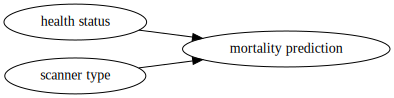

In [2]:
dot = Digraph(format='png')
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', 'y')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

For simplicity, health status is treated as binary: a person is either healthy (1) or not (0). Similarly, we have two types of scanners: portable (1) or non-portable (0). The mortality prediction is the predicted probability of death. Since people who are severely sick often require using the portable scanner, health status and scanner type is negatively correlated, which can be modeled in the following causal graph (note the red edge).

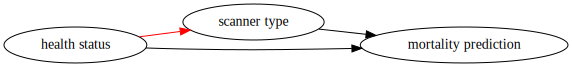

In [3]:
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2', color='red')
dot.edge('1', 'y')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

Now consider the following model that only uses scanner type for prediction:

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status') # 0: unhealthy, 1: healthy
    x2 = Node('scanner type', lambda x1: 1 - x1, [x1]) # 0: not portable, 1: portable
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```

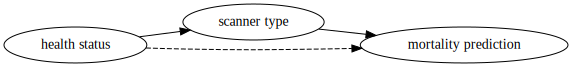

In [4]:
# the causal graph visualization
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2')
dot.edge('1', 'y', style='dashed')
dot.edge('2', 'y')
dot.graph_attr['rankdir']='LR'
dot

How should we assign feature importance given this causal graph?

# Issues with feature attribution methods: showing only direct or indirect effect of features

Let's consider 3 popular model agnostic Shapley value based feature attribution methods: independent SHAP, on manifold SHAP, and asymmetric Shapley value (ASV).
All three methods compares the model output on the target to explain (foreground sample) wiith a eference sample (background sample, often a distribution of samples). For simplicity, we set the foreground value to be a healthy person, and the background sample to be an unhealthy patient.

In [5]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1-x1, [x1])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y])   
    return graph


graph = build_graph() # the causal graph
bg = sample_graph(graph, {'health status': 0})[['health status', 'scanner type']] # background: an unhealthy person
fg = sample_graph(graph, {'health status': 1})[['health status', 'scanner type']] # foreground: a healthy person
f = lambda x: x[:, 1] # function to explain only care about scanner type

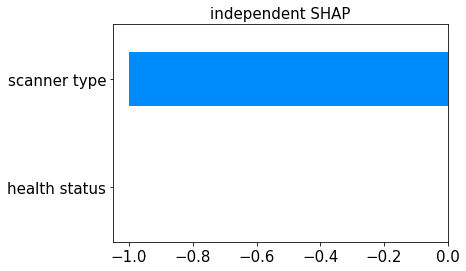

In [6]:
# independent SHAP
cf_ind = IndExplainer(f, bg, silent=True).shap_values(fg)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('independent SHAP', fontsize=15)
plt.show()

Independent SHAP allocates no credit to health status. This is counter intuitive given the fact that changing the health status obviously affect the mortality prediction (therefore how can you justfy not giving any credit to health status)! The issue is that independent SHAP ignores the dependence among features. To address the lack of correlation, one may try using on-manifold SHAP.

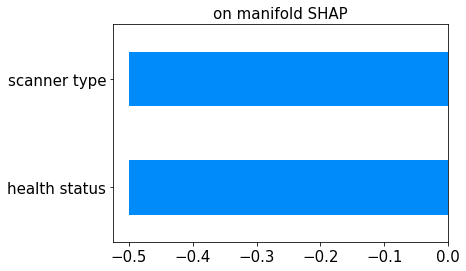

In [7]:
# on manifold SHAP
cf_ind = OnManifoldExplainer(f, pd.concat([bg, fg]), silent=True).shap_values(fg)
cf_ind.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('on manifold SHAP', fontsize=15)
plt.show()

On manifold SHAP gives equal credit to the scanner type and health status because they are equally predictive of each other. Knowing that correlation does not imply causation, in this case knowing that health status is an upstream feature of scanner type, one may attempt to break their symmetry. ASV does exactly that by restricting the feature update ordering to the topological ordering of the graph.

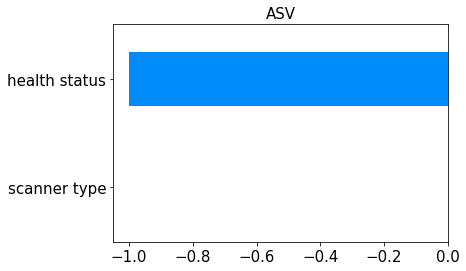

In [8]:
# ASV: restricting the order of on manifold methods
cf_asv = OnManifoldExplainer(f, pd.concat([bg, fg]), orderings=[[0, 1]], silent=True).shap_values(fg)
cf_asv.draw(0) # show the person with index 0 (here we only have 1 person to explain)
plt.title('ASV', fontsize=15)
plt.show()

ASV only allocates credit to health status and ignores the direct effect of scanner type. However, observe that both on-manifold SHAP and ASV will give exactly the same attribution for the following causal structure.

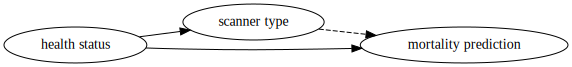

In [9]:
# the causal graph visualization
dot = Digraph()
dot.node('1', 'health status')
dot.node('2', 'scanner type')
dot.node('y', 'mortality prediction')

dot.edge('1', '2')
dot.edge('1', 'y')
dot.edge('2', 'y', style='dashed')
dot.graph_attr['rankdir']='LR'
dot

In [10]:
def build_graph2():
    '''
    show on manifold and ASV are invariant to this graph
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    x2 = Node('scanner type', lambda x1: 1-x1, [x1])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, x2, y])   
    return graph

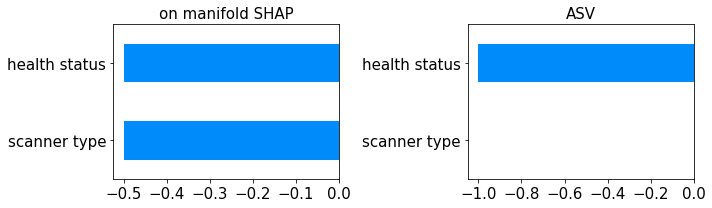

In [11]:
graph2 = build_graph2() # the causal graph
f2 = lambda x: 1 - x[:, 0] # function to explain only care about health status

plt.figure(figsize=(10, 3))
plt.subplot(121)
cf_manifold = OnManifoldExplainer(f2, pd.concat([bg, fg]), silent=True).shap_values(fg)
cf_manifold.draw(0)
plt.title('on manifold SHAP', fontsize=15)

plt.subplot(122)
cf_asv = OnManifoldExplainer(f2, pd.concat([bg, fg]), silent=True, orderings=[[0, 1]]).shap_values(fg)
cf_asv.draw(0)
plt.title('ASV', fontsize=15)
plt.tight_layout()
plt.show()

This is troublesome because the two causal graphs convey distinctly different messages: the first will not work if the causl link between health status breaks in deployment, but the second won't. This means we cannot tell if a model will be robust to causal structure changes using either on manifold SHAP or ASV. 

# How can we elegantly avoids these pitfalls? From feature attribution to edge attribution

One might attempt to advocate running all attribution methods to understand both the direct and indirect impact of features. However, this not only places a huge mental burden on the user, it also wouldn't work when the graph becomes complex (the inter feature influence would be lost). Our idea is to move from feature attribution to edge attribution.

Shapley Flow


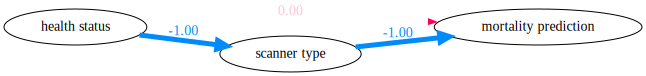

In [12]:
print('Shapley Flow')
cf_flow = GraphExplainer(graph, bg, silent=True).shap_values(fg, rankdir='LR') # rankdir is for visualization direction
d = cf_flow.draw(0, show_fg_val=False) # show the person with index 0 (here we only have 1 person to explain)

Our proposed idea, Shapley Flow, elegantly captures both the direct and indirect impact of features.

To see how Shapley Flow is connected with previous methods, we introduce the notion of boundary. A boundary is a cut that separate the sink node from the source nodes.
![boundary_tutorial1](figures/boundary_tutorial1.png)

Note that the green boundary corresponds to the attribution given by independent SHAP (showing direct impact) and the black boundary corresponds to the attribution given by ASV (showing indirect impact). In general, when the graph is complex, we could have much more cut that ASV and SHAP cannot represent (e.g., the yellow cut in the following graph).

![boundary_tutorial2](figures/boundary_tutorial2.png)

In [13]:
def build_graph_complex(): # graph associated with the above figure
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x00 = Node('enough exercise') # {0, 1}
    x01 = Node('sleep quality') # {0, 1}
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', # low health leads to portable scanner more often
              lambda health, noise: (0.9 > noise if health <= 0.1 else 0.3 > noise).astype(int), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2, 
              [x00, x01, x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y], # background: unhealthy, foreground: healthy
                 {
                      'enough exercise': lambda: 0,
                      'sleep quality': lambda: 0, 
                      'scanner type noise': lambda: np.random.uniform(0, 1)
                 },
                 {
                      'enough exercise': lambda: 1,
                      'sleep quality': lambda: 1,
                      'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

# graph_complex = build_graph_complex()

# How to assign credit? Extending Shapley axioms

We aim to find a sensible way to assign credit. To do that, we take an axiomatic approach, generalizing the classical Shapley value axioms. Informally, we require

1. Boundary consistency: the attribution to an edge from any boundary should be the same.
2. Efficiency: the attribution to edges on any boundary should sum up to the difference between the output on the foreground and the background samples.
3. Linearity: if the prediction function can be linearly decomposed into simpler sub functions, the attribution should be the same linear combination of the sub function's attributions.
4. Dummy: if removing an edge in all scenarios doesn't change the output, it should be given 0 attribution.

Boundary consistency makes sure that the prediction function can be arbitrarily implemented without affecting the attribution (the model can be a blackbox). Efficiency makes sure that our explanation is grounded in contrasting the output of the foreground and the background sample. Linearity makes computation of Shapley value more efficient. Dummy captures the intuition that we shouldn't credit useless edge.

This formulation makes SHAP, ASV, and Owen value special cases of Shapley Flow. It turns out there's a unique attribution to satisfy the axioms.

# How the algorithm works practically?

The following animation shows $1$ random run of the algorithm for the simple graph. Note that this is just a DFS traversal of the graph. The final edge credit is obtained average the edge credit across all possible DFS orderings.

bruteforce sampling:   0%|          | 0/1 [00:00<?, ?it/s]

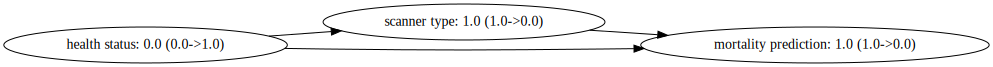


----> using order [health status]
background health status: 0
turn on edge from external source to health status
health status changes from 0 to 1


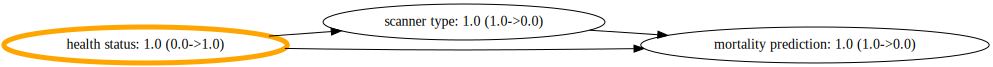

turn on edge health status->scanner type
scanner type changes from 1 to 0


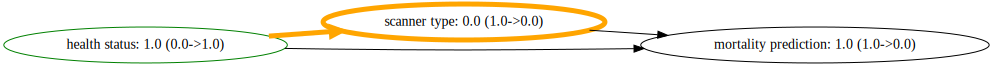

turn on edge scanner type->mortality prediction
mortality prediction changes from 1 to 0


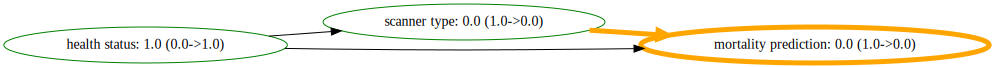

assign -1 credits to scanner type->mortality prediction


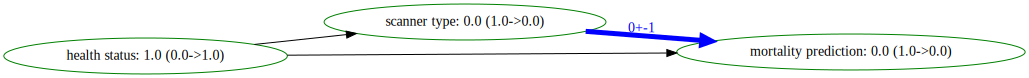

assign -1 credits to health status->scanner type


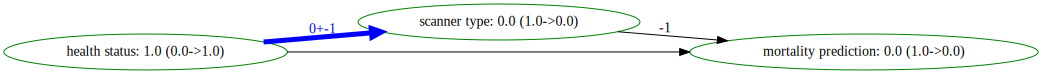

turn on edge health status->mortality prediction
mortality prediction changes from 0 to 0


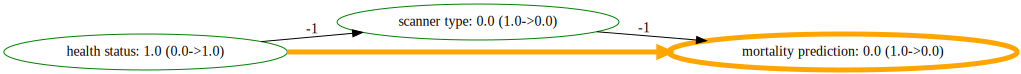

assign 0 credit to health status->mortality prediction


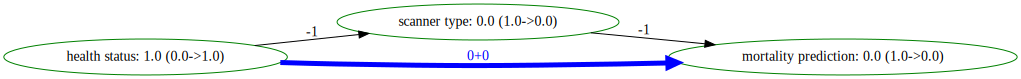

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


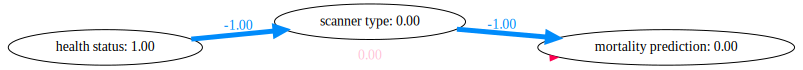

In [14]:
cf = GraphExplainer(graph, bg, nruns=1).shap_values(fg, verbose=True, visualize=True, rankdir='LR')
d = cf.draw(0)